In [3]:
# I will inspect some histograms, in order to work out reasonable mu1, mu2, sigma1, sigma2 values for the mixture model
# I will start by looking at Cam's WOTH data

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [5]:
preds = pd.read_csv('./real_data/sgl60_cam_woth.csv', index_col=[0,1,2])
preds

WOTH_song_x  \
file                                               start_time end_time                
/media/emu/datasets/aru/appl2021e/MSD-1407/2021... 0          4          -21.116142   
                                                   4          8          -20.043306   
                                                   8          12         -18.483469   
                                                   12         16         -21.478302   
                                                   16         20         -18.726887   
...                                                                             ...   
/media/emu/datasets/aru/appl2021e/MSD-1373/2021... 7180       7184       -15.802761   
                                                   7184       7188       -19.777870   
                                                   7188       7192       -20.402475   
                                                   7192       7196       -23.223621   
                                                   7196       7200       -24.935585   

                                                                            site  \
file                                               start_time end_time             
/media/emu/datasets/aru/appl2021e/MSD-1407/2021... 0          4         MSD-1407   
                                                   4          8         MSD-1407   
                                                   8          12        MSD-1407   
                                                   12         16        MSD-1407   
                                                   16         20        MSD-1407   
...                                                                          ...   
/media/emu/datasets/aru/appl2021e/MSD-1373/2021... 7180       7184      MSD-1373   
                                                   7184       7188      MSD-1373   
                                                   7188       7192      MSD-1373   
                                                   7192       7196      MSD-1373   
                                                   7196       7200      MSD-1373   

                                                                            date  \
file                                               start_time end_time             
/media/emu/datasets/aru/appl2021e/MSD-1407/2021... 0          4         20210621   
                                                   4          8         20210621   
                                                   8          12        20210621   
                                                   12         16        20210621   
                                                   16         20        20210621   
...                                                                          ...   
/media/emu/datasets/aru/appl2021e/MSD-1373/2021... 7180       7184      20210518   
                                                   7184       7188      20210518   
                                                   7188       7192      20210518   
                                                   7192       7196      20210518   
                                                   7196       7200      20210518   

                                                                       time_period  \
file                                               start_time end_time               
/media/emu/datasets/aru/appl2021e/MSD-1407/2021... 0          4            600-630   
                                                   4          8            600-630   
                                                   8          12           600-630   
                                                   12         16           600-630   
                                                   16         20           600-630   
...                                                                            ...   
/media/emu/datasets/aru/appl2021e/MSD-1373/2021... 7180       7184

In [6]:
all_data = preds['WOTH_song_x'].values
# fit a gaussian mixture with 2 components to this data
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components=2, covariance_type='full')
gmm.fit(all_data.reshape(-1,1))
print(f"Means found: {gmm.means_}")
print(f"Covariances found: {gmm.covariances_}")
print(f"Weights found: {gmm.weights_}")

/home/lfh/miniconda3/envs/all_tools_py39/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Means found: [[-22.26892675]
 [-28.12374084]]
Covariances found: [[[ 28.63252052]]

 [[130.05880079]]]
Weights found: [0.6819217 0.3180783]


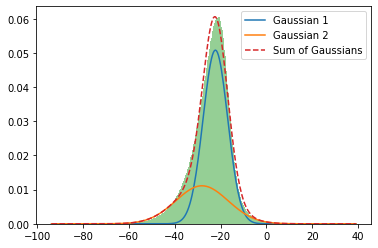

In [7]:
# plot the two gaussian
# I will use the means and covariances found by the GMM
import math
# use large plots rcparams
plt.rcParams['figure.figsize'] = [15, 10]

mu1 = gmm.means_[0][0]
mu2 = gmm.means_[1][0]
sigma1 = math.sqrt(gmm.covariances_[0][0])
sigma2 = math.sqrt(gmm.covariances_[1][0])
x = np.linspace(min(all_data), max(all_data), 300)
y1 = np.exp(-0.5*((x-mu1)/sigma1)**2)/(sigma1*np.sqrt(2*np.pi)) * gmm.weights_[0]
y2 = np.exp(-0.5*((x-mu2)/sigma2)**2)/(sigma2*np.sqrt(2*np.pi)) * gmm.weights_[1]
plt.plot(x, y1, label='Gaussian 1')
plt.plot(x, y2, label='Gaussian 2')
plt.hist(all_data, bins=500, density=True, alpha=0.5)

# add a line for the sum of the two gaussians
y = y1 + y2
plt.plot(x, y, label='Sum of Gaussians', linestyle='--')

plt.legend()

(GaussianMixture(n_components=2),
 <Axes: title={'center': 'Two Component Gaussian Mixture Model on all SGL60 WOTH scores'}, ylabel='Density'>)

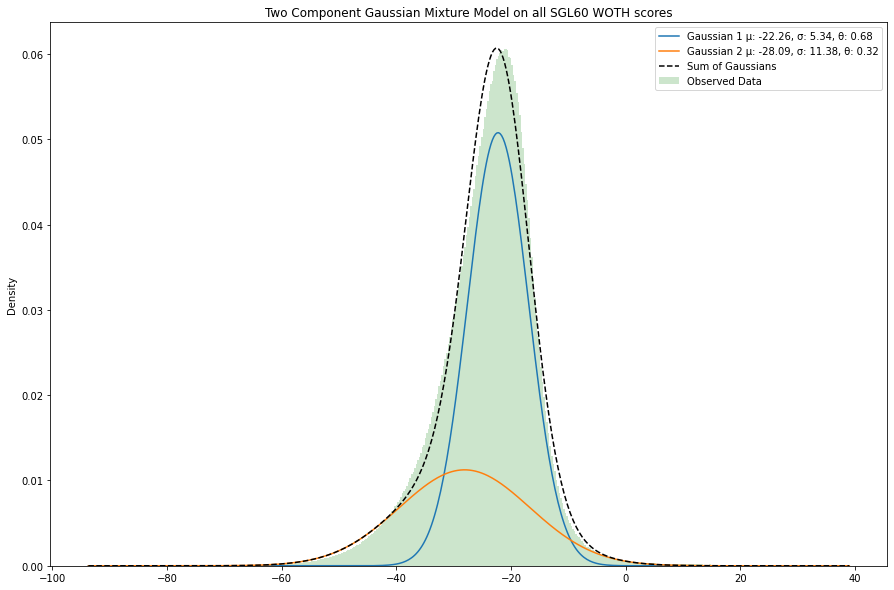

In [8]:
def fit_n_gaussians_and_plot(data, n_components, n_hist_bins, title='Two Component Gaussian Mixture Model', figsize=(15, 10), log=False):
    """
    Fit an n_component Gaussian Mixture Model to the data y and plot the result
    Args:
        data: np.array
        n_components: int
        n_hist_bins: int
        title: str
        figsize: tuple
        log: bool. Whether to fit the normals, or log normals. If True, the histogram will be log transformed before fitting the model
    Returns:
        gmm: sklearn.mixture.GaussianMixture
        ax: matplotlib.axes._subplots.AxesSubplot
    """

    from sklearn.mixture import GaussianMixture
    import math
    
    fig, ax = plt.subplots(figsize=figsize)

    gmm = GaussianMixture(n_components=n_components, covariance_type='full')
    gmm.fit(data.reshape(-1,1))

    means = gmm.means_
    covariances = gmm.covariances_
    weights = gmm.weights_
    
    x = np.linspace(min(data), max(data), n_hist_bins)

    sum_of_gaussians = np.zeros(n_hist_bins)
    for i in range(n_components):
        mu = means[i][0]
        sigma = math.sqrt(covariances[i][0])
        y = np.exp(-0.5*((x-mu)/sigma)**2)/(sigma*np.sqrt(2*np.pi)) * weights[i]
        sum_of_gaussians += y
        ax.plot(x, y, label=f"Gaussian {i+1} μ: {mu:.2f}, σ: {sigma:.2f}, θ: {weights[i]:.2f}", linestyle='-')
    
    # add a line for the sum of the gaussians
    ax.plot(x, sum_of_gaussians, label='Sum of Gaussians', linestyle='--', color='black')

    # add the observed data to the plot
    ax.hist(data, bins=n_hist_bins, density=True, alpha=0.2, color = 'green', label='Observed Data')
    
    ax.set_title(title)
    # label y axis
    ax.set_ylabel('Density')

    ax.legend()

    # set axis y limit
    return (gmm, ax)

fit_n_gaussians_and_plot(all_data, n_components=2, n_hist_bins=500, title='Two Component Gaussian Mixture Model on all SGL60 WOTH scores', figsize=(15, 10), log=False)

In [9]:
positives = preds[preds["WOTH_song_annotation"] == 1]
negatives = preds[preds["WOTH_song_annotation"] == 0]
unknowns = preds[preds["WOTH_song_annotation"].isna()]

In [10]:
len(positives), len(negatives), len(unknowns)

(416, 10905, 6863244)

Text(0.5, 1.0, 'Histogram of WOTH scores for SGL60. Top 1 per site, per day, from 3 time-windows were annotated')

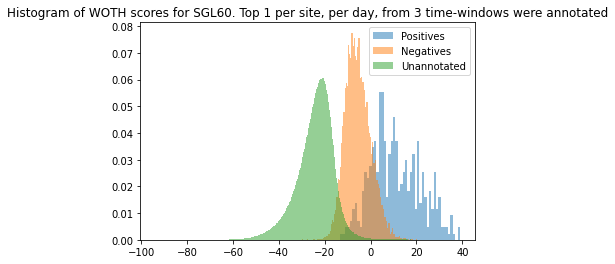

In [11]:
plt.hist(positives['WOTH_song_x'], bins=50, density=True, alpha=0.5, label='Positives')
plt.hist(negatives['WOTH_song_x'], bins=100, density=True, alpha=0.5, label='Negatives')
plt.hist(unknowns['WOTH_song_x'], bins=500, density=True, alpha=0.5, label='Unannotated')
plt.legend()
plt.title('Histogram of WOTH scores for SGL60. Top 1 per site, per day, from 3 time-windows were annotated')

In [12]:
# test the normality of the data using the Shapiro-Wilk test
from scipy.stats import shapiro
shapiro(all_data)

/home/lfh/miniconda3/envs/all_tools_py39/lib/python3.9/site-packages/scipy/stats/morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


ShapiroResult(statistic=0.9660356640815735, pvalue=0.0)

Text(0.5, 1.0, 'Shapiro-Wilk test p-value vs number of samples randomly chosen from sgl_60 WOTH scores (1000 repeats per sample size)')

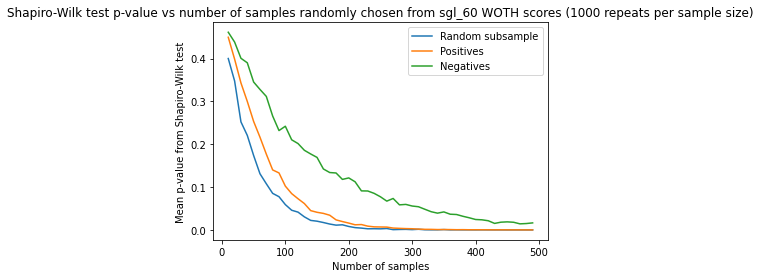

In [13]:
# try subsampling the data, and see how many samples you have to draw in order to fail the shapiro-wilk
subsample_sizes = np.arange(10, 500, 10)
num_repeats = 1000
p_values = np.zeros(len(subsample_sizes))
for i, n in enumerate(subsample_sizes):
    p_values[i] = np.mean([shapiro(np.random.choice(all_data, n))[1] for _ in range(num_repeats)])
plt.plot(subsample_sizes, p_values, label='Random subsample')

for i, n in enumerate(subsample_sizes):
    p_values[i] = np.mean([shapiro(np.random.choice(positives["WOTH_song_x"], n))[1] for _ in range(num_repeats)])
plt.plot(subsample_sizes, p_values, label='Positives')

for i, n in enumerate(subsample_sizes):
    p_values[i] = np.mean([shapiro(np.random.choice(negatives["WOTH_song_x"], n))[1] for _ in range(num_repeats)])
plt.plot(subsample_sizes, p_values, label='Negatives')

plt.legend()
plt.xlabel('Number of samples')
plt.ylabel('Mean p-value from Shapiro-Wilk test')
plt.title(f'Shapiro-Wilk test p-value vs number of samples randomly chosen from sgl_60 WOTH scores ({num_repeats} repeats per sample size)')

In [14]:
# maybe I can try quantifying distribution shift by picking a relatively large number of samples, then calculating the KL divergence between the distributions of the samples
def subset_by_method(all_data, data_to_match, method, **kwargs):
    """
    A function for subsetting data, according to the method specified
    Args:
        all_data: pandas.DataFrame, containing all the data, and the columns to subset by
        data_to_match: pandas.DataFrame, containing the data that you're going to match. This data should not be present in all_data 
                        (to avoid getting the same data back when querying all_data). 
        method: str. One of "site", "date", "time_period", "site-date", "site-time_period", "date-time_period", "site-date-time_period"
    Returns:
        subset: pandas.DataFrame
    """

    matching_site = data_to_match["site"].sample(1).values[0]
    matching_date = data_to_match["date"].sample(1).values[0]
    matching_time_period = data_to_match["time_period"].sample(1).values[0]

    # check that data_to_match is not present in all_data
    # do this by checking the index
    assert data_to_match.index.isin(all_data.index).sum() == 0, "The data to match should not be present in all_data"
    
    if method == "site":
        assert data_to_match["site"].nunique() == 1, "The data to match should only contain data from one site"
        subset = all_data[all_data["site"] == matching_site]
    elif method == "date":
        assert data_to_match["date"].nunique() == 1, "The data to match should only contain data from one day"
        subset = all_data[all_data["date"] == random_day]
    elif method == "time_period":
        assert data_to_match["time_period"].nunique() == 1, "The data to match should only contain data from one time period"
        subset = all_data[all_data["time_period"] == matching_time_period]
    elif method == "site-date":
        assert data_to_match["site"].nunique() == 1, "The data to match should only contain data from one site"
        subset = all_data[(all_data["site"] == matching_site) & (all_data["date"] == matching_date)]
    elif method == "site-time_period":
        assert data_to_match["site"].nunique() == 1, "The data to match should only contain data from one site"
        assert data_to_match["time_period"].nunique() == 1, "The data to match should only contain data from one time period"
        subset = all_data[(all_data["site"] == matching_site) & (all_data["time_period"] == matching_time_period)]
    elif method == "date-time_period":
        assert data_to_match["date"].nunique() == 1, "The data to match should only contain data from one day"
        assert data_to_match["time_period"].nunique() == 1, "The data to match should only contain data from one time period"
        subset = all_data[(all_data["date"] == matching_date) & (all_data["time_period"] == matching_time_period)]          
    elif method == "site-date-time_period":
        assert data_to_match["site"].nunique() == 1, "The data to match should only contain data from one site"
        assert data_to_match["date"].nunique() == 1, "The data to match should only contain data from one day"
        assert data_to_match["time_period"].nunique() == 1, "The data to match should only contain data from one time period"
        subset = all_data[(all_data["site"] == matching_site) & (all_data["date"] == matching_date) & (all_data["time_period"] == matching_time_period)]
    else:
        raise ValueError(f"Method {method} not recognised")
    
    return subset

def KLdivergence(x, y):
  """Compute the Kullback-Leibler divergence between two multivariate samples.
  Parameters
  ----------
  x : 2D array (n,d)
    Samples from distribution P, which typically represents the true
    distribution.
  y : 2D array (m,d)
    Samples from distribution Q, which typically represents the approximate
    distribution.
  Returns
  -------
  out : float
    The estimated Kullback-Leibler divergence D(P||Q).
  References
  ----------
  Pérez-Cruz, F. Kullback-Leibler divergence estimation of
continuous distributions IEEE International Symposium on Information
Theory, 2008.
  """
  from scipy.spatial import cKDTree as KDTree

  # Check the dimensions are consistent
  x = np.atleast_2d(x)
  y = np.atleast_2d(y)

  n,d = x.shape
  m,dy = y.shape

  assert(d == dy)


  # Build a KD tree representation of the samples and find the nearest neighbour
  # of each point in x.
  xtree = KDTree(x)
  ytree = KDTree(y)

  # Get the first two nearest neighbours for x, since the closest one is the
  # sample itself.
  r = xtree.query(x, k=2, eps=.01, p=2)[0][:,1]
  s = ytree.query(x, k=1, eps=.01, p=2)[0]

  # There is a mistake in the paper. In Eq. 14, the right side misses a negative sign
  # on the first term of the right hand side.
  return -np.log(r/s).sum() * d / n + np.log(m / (n - 1.))

In [ ]:
# drop the time_periods that are NAs
only_complete_time_periods = preds.dropna(subset=["time_period"])

In [67]:
# pick a random site, date and time_period
num_iterations = 500
kl_divergences = {}

# get every site-date-time_period combination that has more than 400 samples
possible_date_time_periods = only_complete_time_periods.groupby(["site", "date", "time_period"]).size().reset_index()
possible_date_time_periods = possible_date_time_periods[possible_date_time_periods[0] > 400]

for subsetting_method in ["site", "date", "time_period", "site-date", "site-time_period", "date-time_period", "site-date-time_period"]:

    divergences = []
    
    for i in range(num_iterations):
        # pick a random site, date and time_period from the possible combinations
        row = possible_date_time_periods.sample(1)
        random_site = row["site"].values[0]
        random_day = row["date"].values[0]
        random_time_period = row["time_period"].values[0]

        # get all the data that matches the random site, date and time_period
        all_data_to_match = only_complete_time_periods[(only_complete_time_periods["site"] == random_site) & (only_complete_time_periods["date"] == random_day) & (only_complete_time_periods["time_period"] == random_time_period)]
        
        # sample some of that data
        data_to_match = all_data_to_match.sample(200, replace = False) # half the size of the average site-date-time_period subset

        # drop those samples from the remaining data
        remaining_data = only_complete_time_periods.drop(data_to_match.index) # drop the data that was sampled

        # subset the remaining data to find those that match, according to the subsetting_method
        subset = subset_by_method(remaining_data, data_to_match, subsetting_method)
        print(f"{subsetting_method}: {len(subset)} samples")
        divergences.append(KLdivergence(data_to_match["WOTH_song_x"].values.reshape(-1, 1), subset["WOTH_song_x"].values.reshape(-1, 1)))
        
    kl_divergences[subsetting_method] = divergences

site: 75344 samples
site: 71341 samples


/tmp/ipykernel_428328/2676623353.py:96: RuntimeWarning: divide by zero encountered in divide
  return -np.log(r/s).sum() * d / n + np.log(m / (n - 1.))


site: 75152 samples
site: 75324 samples
site: 75400 samples


/tmp/ipykernel_428328/2676623353.py:96: RuntimeWarning: divide by zero encountered in divide
  return -np.log(r/s).sum() * d / n + np.log(m / (n - 1.))


date: 92950 samples
date: 92950 samples


/tmp/ipykernel_428328/2676623353.py:96: RuntimeWarning: divide by zero encountered in divide
  return -np.log(r/s).sum() * d / n + np.log(m / (n - 1.))


date: 92950 samples


/tmp/ipykernel_428328/2676623353.py:96: RuntimeWarning: divide by zero encountered in divide
  return -np.log(r/s).sum() * d / n + np.log(m / (n - 1.))


date: 92950 samples


/tmp/ipykernel_428328/2676623353.py:96: RuntimeWarning: divide by zero encountered in divide
  return -np.log(r/s).sum() * d / n + np.log(m / (n - 1.))


date: 91600 samples


/tmp/ipykernel_428328/2676623353.py:96: RuntimeWarning: divide by zero encountered in divide
  return -np.log(r/s).sum() * d / n + np.log(m / (n - 1.))


time_period: 1716005 samples


/tmp/ipykernel_428328/2676623353.py:96: RuntimeWarning: divide by zero encountered in divide
  return -np.log(r/s).sum() * d / n + np.log(m / (n - 1.))


time_period: 1708472 samples


/tmp/ipykernel_428328/2676623353.py:96: RuntimeWarning: divide by zero encountered in divide
  return -np.log(r/s).sum() * d / n + np.log(m / (n - 1.))


time_period: 1716005 samples


/tmp/ipykernel_428328/2676623353.py:96: RuntimeWarning: divide by zero encountered in divide
  return -np.log(r/s).sum() * d / n + np.log(m / (n - 1.))


time_period: 1733287 samples


/tmp/ipykernel_428328/2676623353.py:96: RuntimeWarning: divide by zero encountered in divide
  return -np.log(r/s).sum() * d / n + np.log(m / (n - 1.))


time_period: 1733287 samples


/tmp/ipykernel_428328/2676623353.py:96: RuntimeWarning: divide by zero encountered in divide
  return -np.log(r/s).sum() * d / n + np.log(m / (n - 1.))


site-date: 1150 samples
site-date: 1150 samples
site-date: 1150 samples
site-date: 1150 samples
site-date: 1150 samples
site-time_period: 24550 samples


/tmp/ipykernel_428328/2676623353.py:96: RuntimeWarning: divide by zero encountered in divide
  return -np.log(r/s).sum() * d / n + np.log(m / (n - 1.))


site-time_period: 25000 samples


/tmp/ipykernel_428328/2676623353.py:96: RuntimeWarning: divide by zero encountered in divide
  return -np.log(r/s).sum() * d / n + np.log(m / (n - 1.))


site-time_period: 24550 samples


/tmp/ipykernel_428328/2676623353.py:96: RuntimeWarning: divide by zero encountered in divide
  return -np.log(r/s).sum() * d / n + np.log(m / (n - 1.))


site-time_period: 24810 samples
site-time_period: 25000 samples
date-time_period: 30207 samples
date-time_period: 30850 samples


/tmp/ipykernel_428328/2676623353.py:96: RuntimeWarning: divide by zero encountered in divide
  return -np.log(r/s).sum() * d / n + np.log(m / (n - 1.))


date-time_period: 30850 samples
date-time_period: 30182 samples


/tmp/ipykernel_428328/2676623353.py:96: RuntimeWarning: divide by zero encountered in divide
  return -np.log(r/s).sum() * d / n + np.log(m / (n - 1.))


date-time_period: 30850 samples
site-date-time_period: 250 samples
site-date-time_period: 250 samples
site-date-time_period: 250 samples
site-date-time_period: 250 samples
site-date-time_period: 250 samples


In [75]:
pd.to_csv(kl_divergences, "kl_divergences.csv")

{'site': [-0.003554295381120731,
  -inf,
  0.17390634042973208,
  0.6773922434014601,
  -inf],
 'date': [0.11465519120075474, -inf, -inf, -inf, -inf],
 'time_period': [-inf, -inf, -inf, -inf, -inf],
 'site-date': [0.2923080690466622,
  0.45990294712903346,
  0.2104036149780042,
  0.8779002100151262,
  0.15965580811578528],
 'site-time_period': [-inf,
  -inf,
  -inf,
  -0.10206779581436365,
  0.058791532949849845],
 'date-time_period': [-0.1250586471950177,
  -inf,
  0.2588783899764966,
  -inf,
  0.1795135589697825],
 'site-date-time_period': [-0.11317042241795697,
  -0.050334642460501816,
  -0.10571709414282757,
  0.16974210129348077,
  0.21478267519616903]}

In [78]:
# iterate through each method and calculate the means.  I will treat every -inf as a NaN, and just ignore it for the sake of mean calculation
means = {}
for method, kl_divergence in kl_divergences.items():
    kl_divergence = np.array(kl_divergence)
    kl_divergence[kl_divergence == -np.inf] = np.nan
    print(f"{method}: {np.nanmean(kl_divergence)}")
    means[method] = np.nanmean(kl_divergence)

site: 0.2825814294833571
date: 0.11465519120075474
time_period: nan
site-date: 0.4000341298569222
site-time_period: -0.021638131432256902
date-time_period: 0.10444443391708713
site-date-time_period: 0.023060523493672696


/tmp/ipykernel_428328/3709267318.py:6: RuntimeWarning: Mean of empty slice
  print(f"{method}: {np.nanmean(kl_divergence)}")
/tmp/ipykernel_428328/3709267318.py:7: RuntimeWarning: Mean of empty slice
  means[method] = np.nanmean(kl_divergence)


<BarContainer object of 7 artists>

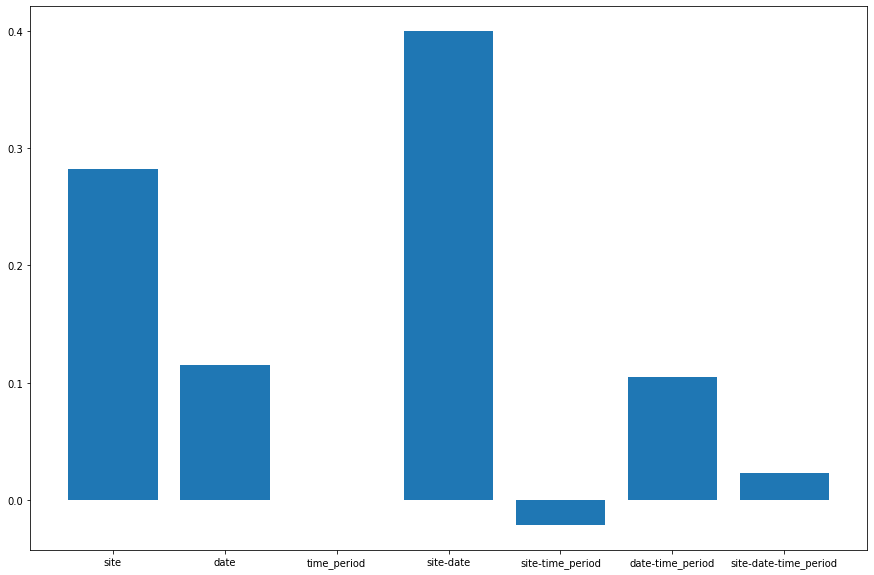

In [83]:
# big plot rcparams
plt.rcParams['figure.figsize'] = [15, 10]
plt.bar(means.keys(), means.values())